# Projection d'orthophotos sur un plan et superposition sur une couche Google

## 1. Installation des bibliothèques nécessaires

```bash
pip install rasterio geopandas folium
```

## 2. Import des librairies

In [2]:
import glob
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import folium

## 3. Chargement et comptage des orthophotos

In [3]:
# Spécifiez le chemin vers votre dossier d'orthophotos
folder = 'ortho'
pattern = '*.tif'  # ou '*.tiff'
files = glob.glob(os.path.join(folder, pattern))
print(f"Nombre d'orthophotos dans le dossier : {len(files)}")

Nombre d'orthophotos dans le dossier : 5


## 4. Projection et superposition des orthophotos sur une carte Google


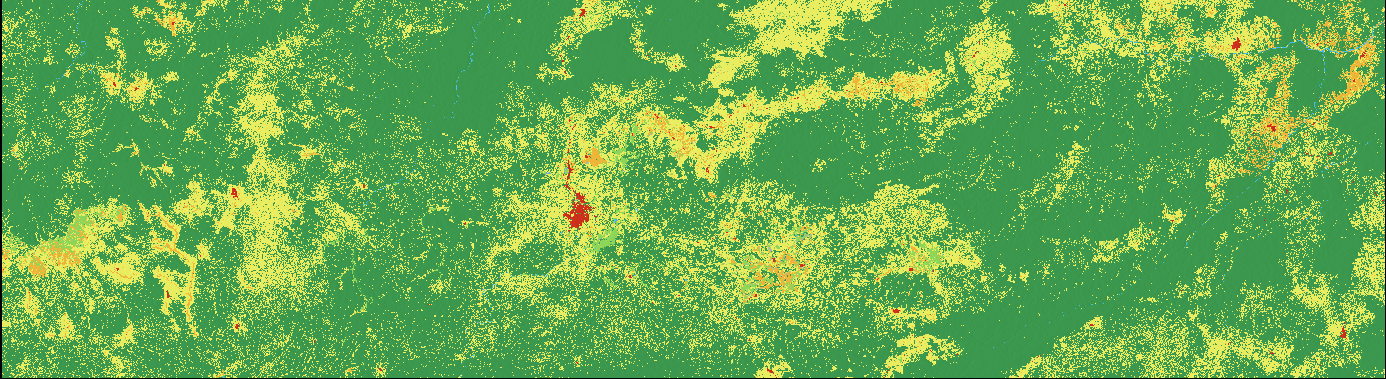
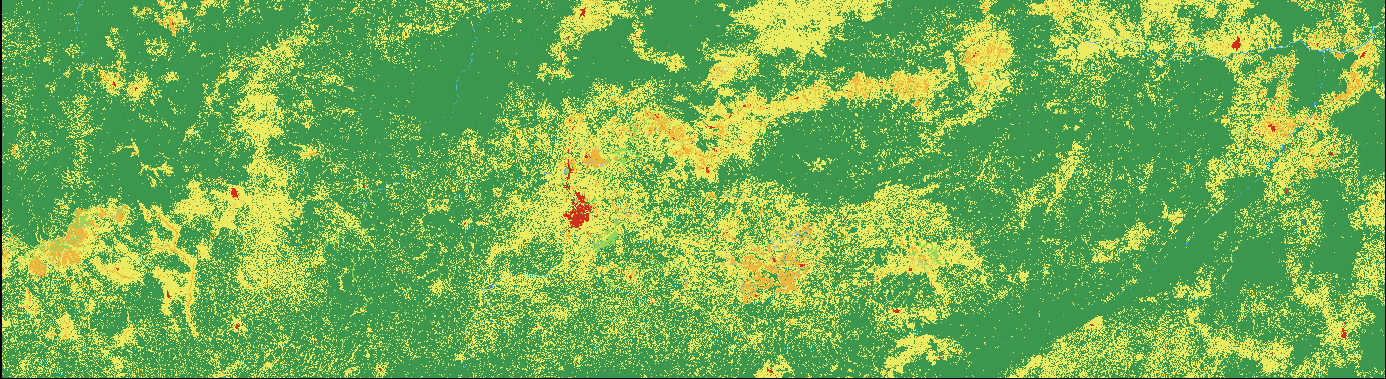
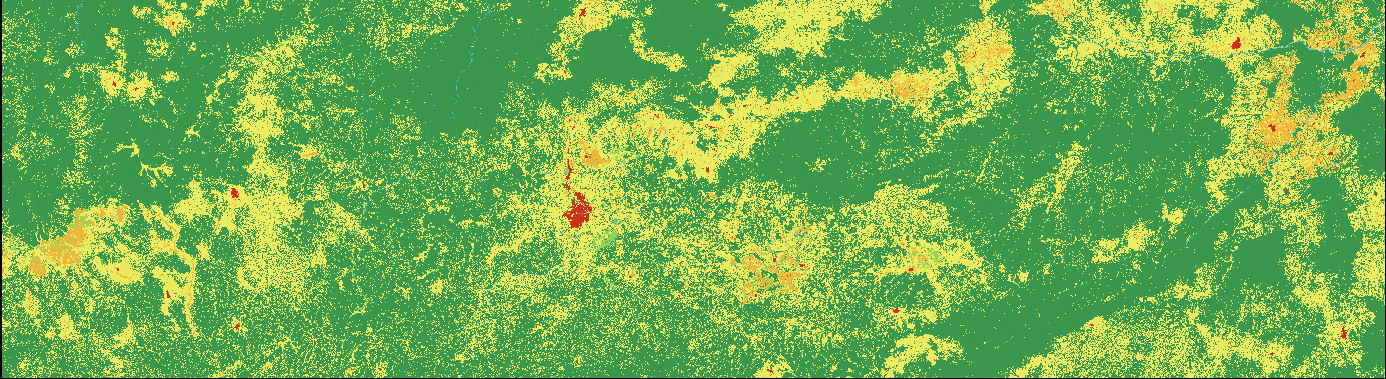
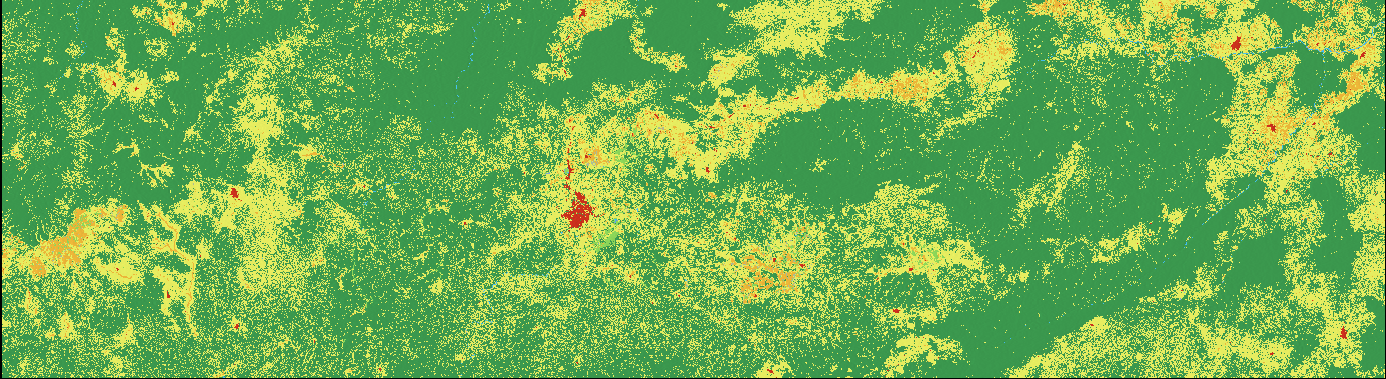
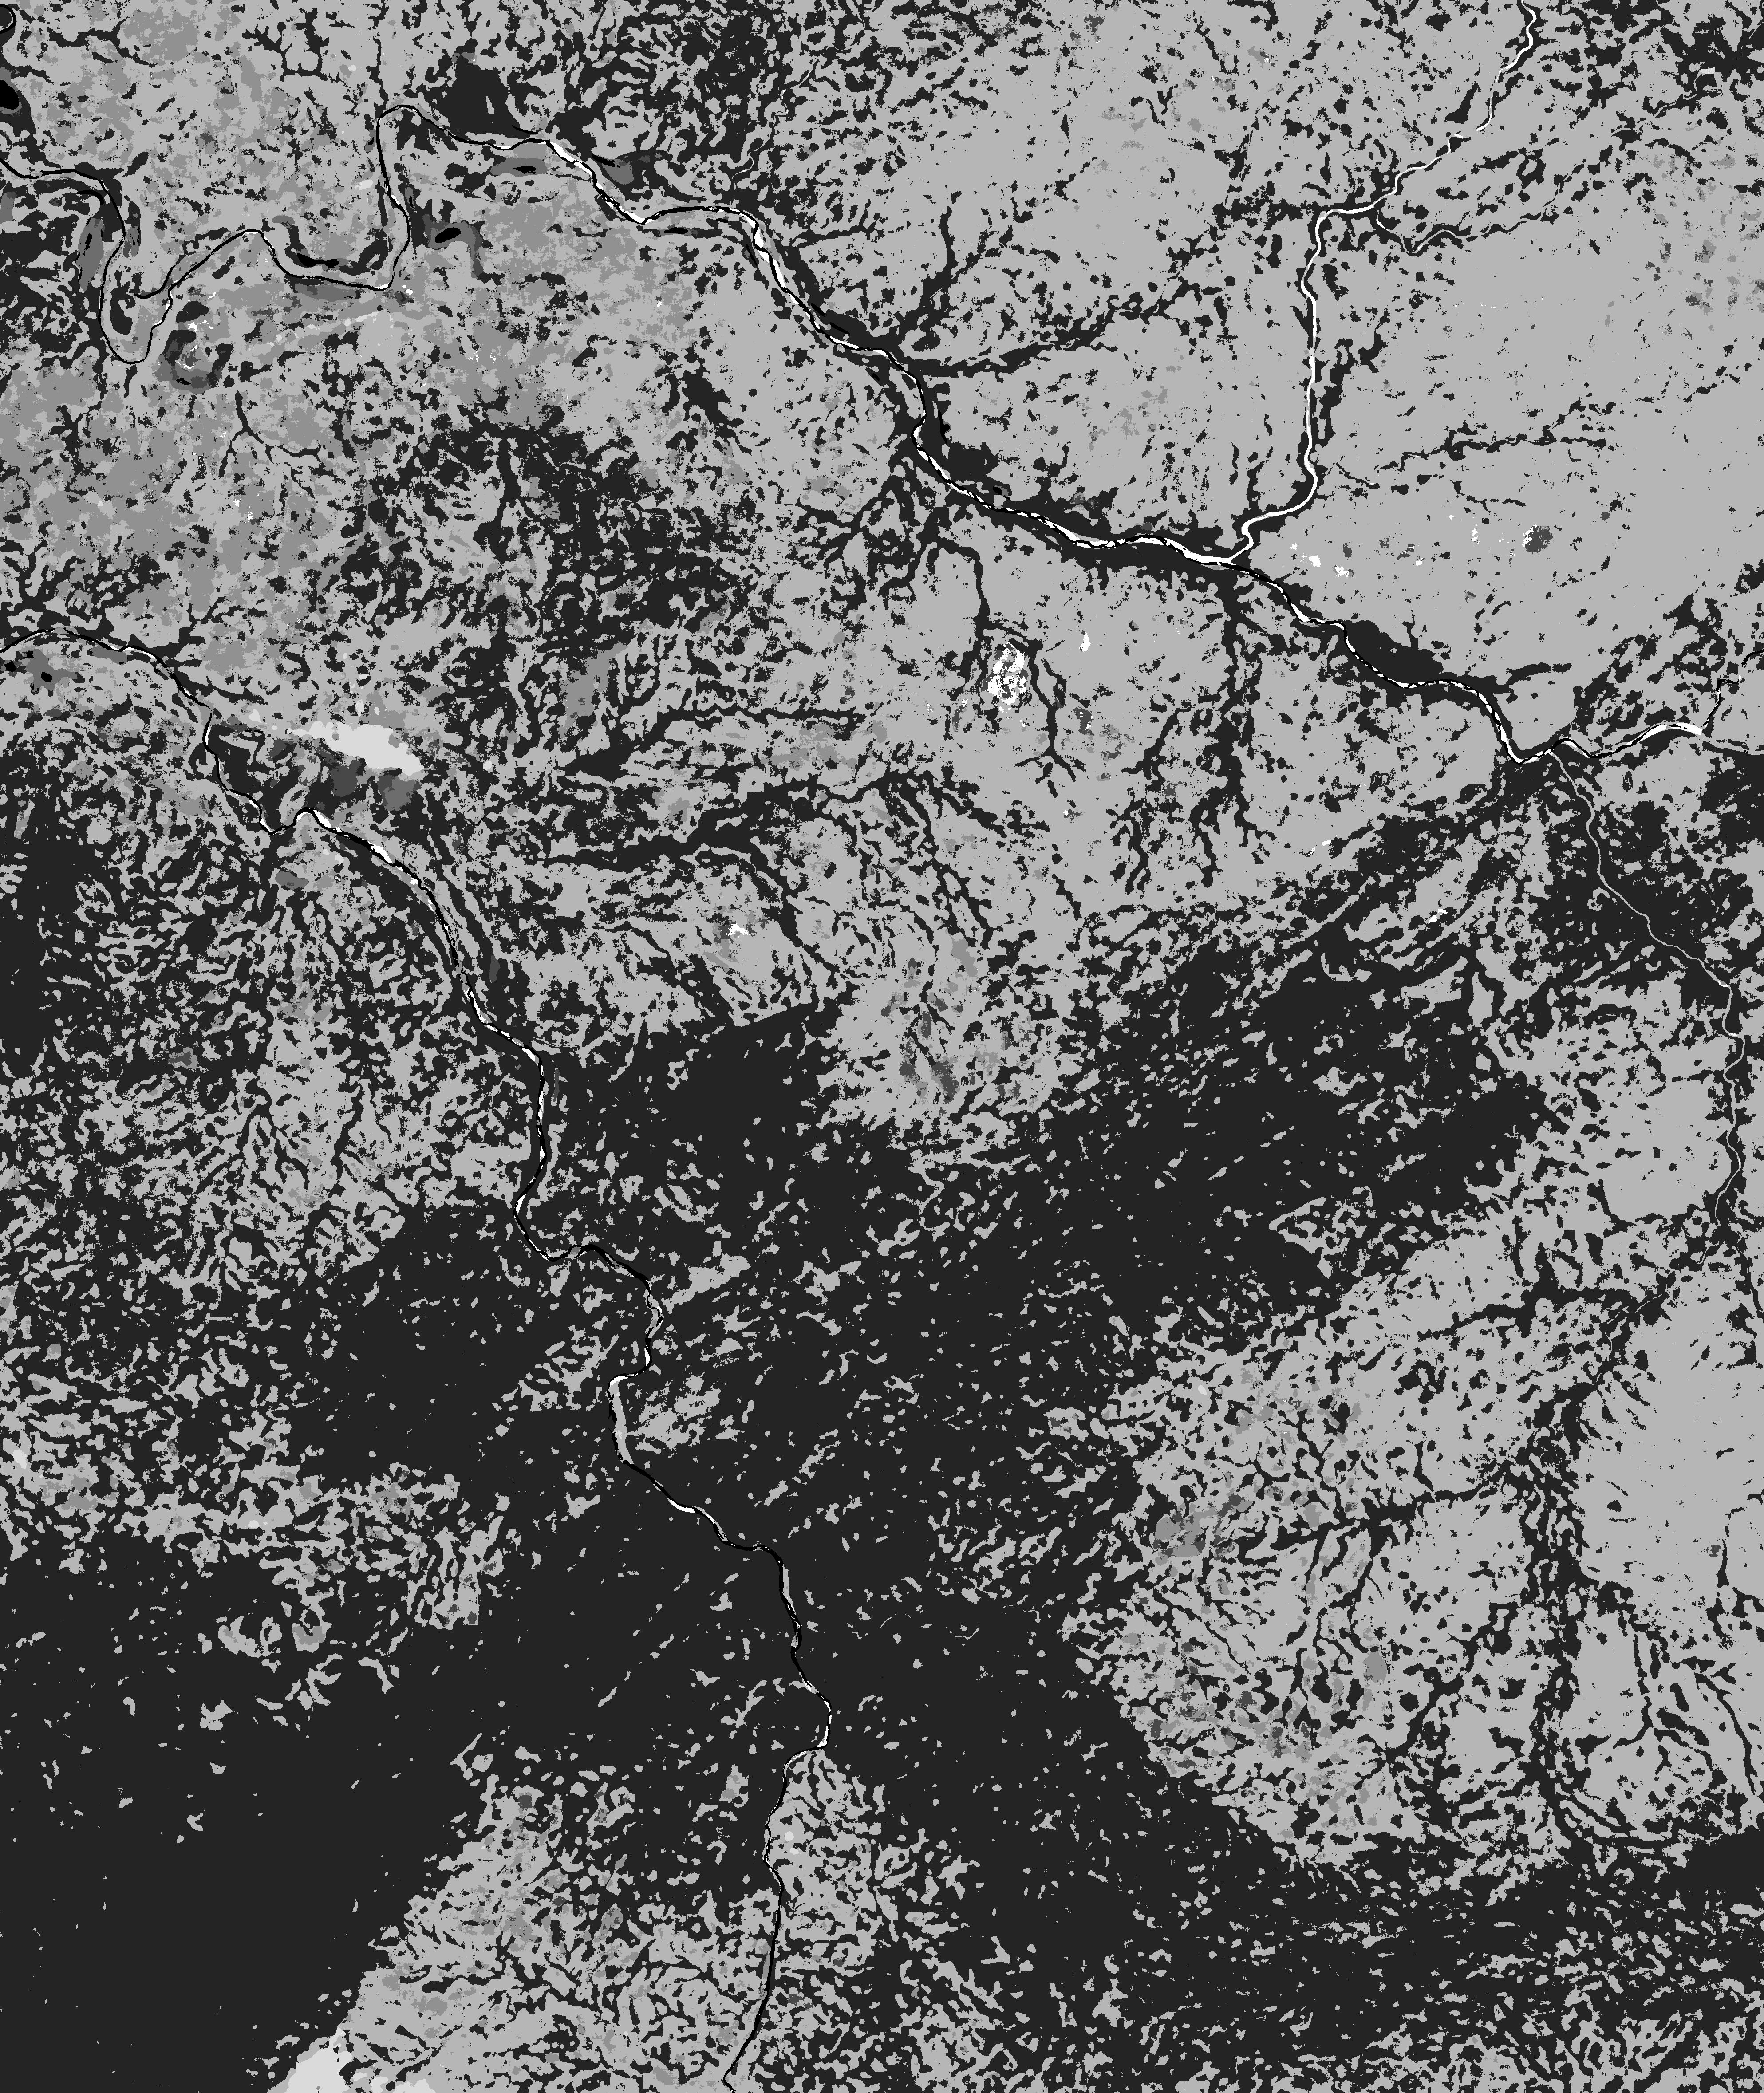

In [4]:
m = None
for file in files:
    with rasterio.open(file) as src:
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})

        # Réprojection dans un tableau en mémoire
        destination = np.zeros((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=src.read(i),
                destination=destination[i-1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

        # Construction de l'image RGB (3 premières bandes)
        img = np.dstack([destination[i] for i in range(min(3, src.count))])

        # Détermination des limites géographiques
        left, bottom = transform * (0, height)
        right, top = transform * (width, 0)

        # Initialisation de la carte
        if m is None:
            center = [(top + bottom) / 2, (left + right) / 2]
            m = folium.Map(location=center, zoom_start=12, tiles=None)
            # Ajout du fond Google Satellite
            folium.TileLayer(
                tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                attr='Google Satellite',
                name='Google Satellite',
                overlay=False,
                control=True
            ).add_to(m)

        # Superposition de l'orthophoto
        folium.raster_layers.ImageOverlay(
            image=img,
            bounds=[[bottom, left], [top, right]],
            opacity=0.6,
            name=os.path.basename(file)
        ).add_to(m)

# Ajout des contrôles de couches
folium.LayerControl().add_to(m)

# Affichage de la carte
m

**Remarque :** Remplacez `'path_to_orthophotos_folder'` par le chemin réel vers votre dossier contenant les orthophotos.